# Hyperelastic shaft under rigid-body rotation

Here we import the libraries required for defining and solving the problem.

In [73]:
# Import essential libraries for FEM using FEniCSx

import numpy as np                     # Numerical computations
import ufl                            # Unified Form Language for variational formulations

from mpi4py import MPI                # MPI support for parallel computing
from dolfinx import fem, io, nls      # FEniCSx interfaces for FEM, I/O, and nonlinear solvers
import dolfinx.fem.petsc              # PETSc-based backend for assembling and solving systems
import dolfinx.nls.petsc              # PETSc-based nonlinear solver support
from dolfinx.mesh import create_box, CellType  # Mesh generation utilities

from ufl import (                     # UFL tools for defining variational forms
    as_matrix, dot, cos, sin, SpatialCoordinate,
    Identity, grad, ln, tr, det, variable,
    derivative, TestFunction, TrialFunction,
)


Then, we define the 3D mesh, finite element function space, and initialize the displacement field


In [74]:
# Define mesh parameters
L = 10.0        # Length of the beam in the z-direction
N = 1          # Number of elements in x and y directions

# Create a structured hexahedral mesh in the domain [-0.5, 0.5] × [-0.5, 0.5] × [0, L]
# with 5*N elements along the length for finer resolution in z
mesh = create_box(
    MPI.COMM_WORLD,
    [[-0.5, -0.5, 0.0], [0.5, 0.5, L]],
    [N, N, 5 * N],
    CellType.hexahedron,
)

# Get the topological dimension of the mesh (should be 3 for a 3D mesh)
dim = mesh.topology.dim
print(f"Mesh topology dimension d={dim}.")

# Define vector-valued function space of degree 1 Lagrange elements ("P", 1)
# for 3D displacement field
degree = 1
shape = (dim,)
V = fem.functionspace(mesh, ("P", degree, shape))

# Initialize the displacement field as a Function on the space V
u = fem.Function(V, name="Displacement")


Mesh topology dimension d=3.


Now, we define kinematics, material parameters, and Neo-Hookean strain energy function and compute the first Piola-Kirchhoff stress tensor.


In [75]:
# Identity tensor of appropriate dimension (3x3 for 3D problems)
Id = Identity(dim)

# Deformation gradient: F = I + ∇u (u is displacement field)
F = variable(Id + grad(u))

# Right Cauchy-Green deformation tensor: C = Fᵀ·F
C = F.T * F

# First invariant of C (trace of C)
I1 = tr(C)

# Jacobian determinant: J = det(F), measure of local volume change
J = det(F)

# Material parameters: Young's modulus E and Poisson's ratio nu
E = 1e4
nu = 0.4

# Lame parameters: shear modulus μ and first Lame parameter λ
mu = fem.Constant(mesh, E / (2 * (1 + nu)))  # μ = E / (2(1 + ν))
lmbda = fem.Constant(mesh, E * nu / ((1 + nu) * (1 - 2 * nu)))  # λ = Eν / ((1 + ν)(1 - 2ν))

# Compressible Neo-Hookean strain energy density function:
# psi = μ/2 (I1 - 3 - 2 ln(J)) + λ/2 (J - 1)^2
psi = mu / 2 * (I1 - 3 - 2 * ln(J)) + lmbda / 2 * (J - 1) ** 2

# First Piola-Kirchhoff stress tensor: P = ∂ψ/∂F
P = ufl.diff(psi, F)

# Print symbolic expression of the PK1 stress for verification/debugging
print(P)

d/d[var8(I + (grad(Displacement)))] ((-3 + (tr({ A | A_{i_{40}, i_{41}} = sum_{i_{42}} (var8(I + (grad(Displacement))))[i_{42}, i_{41}] * ((var8(I + (grad(Displacement))))^T)[i_{40}, i_{42}]  })) + -1 * 2 * ln(det(var8(I + (grad(Displacement)))))) * c_24 / 2 + c_25 / 2 * (-1 + (det(var8(I + (grad(Displacement)))))) ** 2)


Subsequently, we mark bottom and top surfaces and apply Dirichlet boundary conditions.


In [76]:
# Define geometric marker functions for the bottom and top surfaces
# Bottom face: z = 0
def bottom(x):
    return np.isclose(x[2], 0.0)

# Top face: z = L
def top(x):
    return np.isclose(x[2], L)

# Locate degrees of freedom (DoFs) associated with the bottom and top surfaces
bottom_dofs = fem.locate_dofs_geometrical(V, bottom)
top_dofs = fem.locate_dofs_geometrical(V, top)

# Define zero-valued displacement functions for bottom and top
# These can be later updated (e.g. to impose rotation or displacement)
u_bot = fem.Function(V)  # Displacement at bottom (typically fixed)
u_top = fem.Function(V)  # Displacement at top (e.g., imposed loading or rotation)

# Apply Dirichlet boundary conditions to both surfaces
bcs = [
    fem.dirichletbc(u_bot, bottom_dofs),  # Fix bottom face
    fem.dirichletbc(u_top, top_dofs),     # Displacement-controlled top face
]


Then, we define rigid body rotation about the z-axis and interpolate it for top boundary displacement


In [77]:
# Define spatial coordinate vector (symbolic variable x = [x, y, z])
x = SpatialCoordinate(mesh)

# Define rotation angle (in radians) as a time-varying constant
theta = fem.Constant(mesh, 0.0)

# Define rotation matrix about the z-axis by angle θ (standard 3D rotation matrix)
Rot = as_matrix([
    [cos(theta),  sin(theta), 0],
    [-sin(theta), cos(theta), 0],
    [0,           0,          1]
])

# Define displacement due to rotation: u_rot = R·x - x
# This gives the vector field corresponding to rigid body rotation
rotation_displ = dot(Rot, x) - x

# Interpolate the symbolic displacement expression into a discrete FEM expression
# This will be evaluated and applied to the top surface
rot_expr = fem.Expression(rotation_displ, V.element.interpolation_points())

After that, we define the total potential energy, residual, and Jacobian for the nonlinear variational problem


In [78]:
# Define integration measure over the domain with specified quadrature degree
dx = ufl.Measure("dx", domain=mesh, metadata={"quadrature_degree": 4})

# Define the total potential energy functional (integral of strain energy density)
E_pot = psi * dx

# Define test and trial functions for the variational formulation
v = TestFunction(V)   # Virtual displacement (for residual)
du = TrialFunction(V) # Incremental displacement (for Jacobian)

# Define residual of the nonlinear system: R(u) = δΠ = d(E_pot)/d(u) · v
# Equivalent to ∫ P : ∇v dx for hyperelasticity
Residual = derivative(E_pot, u, v)

# Define Jacobian of the residual (tangent stiffness matrix)
# J(u) = d²(E_pot)/d(u)² · (du, v)
Jacobian = derivative(Residual, u, du)

Then, we set up the nonlinear problem and the Newton-Raphson solver with tolerances

In [79]:
# Define the nonlinear variational problem: find u such that Residual(u) = 0
# Applies Dirichlet boundary conditions through `bcs`
problem = fem.petsc.NonlinearProblem(Residual, u, bcs)

# Create a Newton-Raphson solver using PETSc
solver = nls.petsc.NewtonSolver(mesh.comm, problem)

# Set solver tolerances and convergence criterion
solver.atol = 1e-4                         # Absolute tolerance
solver.rtol = 1e-4                         # Relative tolerance
solver.convergence_criterion = "incremental"  # Converges when update increment is small

Fianlly, we rotate the beam incrementally, solve the nonlinear problem at each step, and record corner displacement.

In [80]:
# Define maximum rotation angle (full 360 degrees) and number of increments
angle_max = 2 * np.pi
Nsteps = 20

# Output file for visualizing results in ParaView
out_file = "hyperelasticity.xdmf"
with io.XDMFFile(mesh.comm, out_file, "w") as xdmf:
    xdmf.write_mesh(mesh)  # Write mesh once at the beginning

# Define a top corner point (e.g., +x, +y, top z)
corner_coords = np.array([0.5, 0.5, L])
corner_index = np.argmin(np.linalg.norm(mesh.geometry.x - corner_coords, axis=1))

# Initialize storage for plotting
corner_displacements_x = []
angles_deg = []

# Initialize displacement field to zero
u.x.array[:] = 0.0

# Loop over time steps / rotation increments
for n, angle in enumerate(np.linspace(0, angle_max, Nsteps + 1)[1:]):
    # Update rotation angle
    theta.value = angle

    # Interpolate updated top displacement expression for current rotation
    u_top.interpolate(rot_expr)

    # Solve nonlinear system
    num_its, converged = solver.solve(u)
    assert converged  # Ensure solver convergence

    # Synchronize ghost values (important for parallel runs)
    u.x.scatter_forward()

    # Record x-displacement at selected corner
    u_corner = u.x.array.reshape(-1, 3)[corner_index]
    corner_displacements_x.append(u_corner[0])  # x-component only
    angles_deg.append(angle * 180 / np.pi)      # angle in degrees

    # Log progress
    print(
        f"Time step {n}, Number of iterations {num_its}, Angle {angle*180/np.pi:.0f} deg."
    )

    # Append current displacement solution to output file for visualization
    with io.XDMFFile(mesh.comm, out_file, "a") as xdmf:
        xdmf.write_function(u, n + 1)

Time step 0, Number of iterations 5, Angle 18 deg.
Time step 1, Number of iterations 6, Angle 36 deg.
Time step 2, Number of iterations 7, Angle 54 deg.
Time step 3, Number of iterations 7, Angle 72 deg.
Time step 4, Number of iterations 7, Angle 90 deg.
Time step 5, Number of iterations 7, Angle 108 deg.
Time step 6, Number of iterations 7, Angle 126 deg.
Time step 7, Number of iterations 7, Angle 144 deg.
Time step 8, Number of iterations 7, Angle 162 deg.
Time step 9, Number of iterations 6, Angle 180 deg.
Time step 10, Number of iterations 6, Angle 198 deg.
Time step 11, Number of iterations 6, Angle 216 deg.
Time step 12, Number of iterations 6, Angle 234 deg.
Time step 13, Number of iterations 6, Angle 252 deg.
Time step 14, Number of iterations 6, Angle 270 deg.
Time step 15, Number of iterations 6, Angle 288 deg.
Time step 16, Number of iterations 6, Angle 306 deg.
Time step 17, Number of iterations 5, Angle 324 deg.
Time step 18, Number of iterations 5, Angle 342 deg.
Time ste

Here, we compare the analytical and numerical solutions.

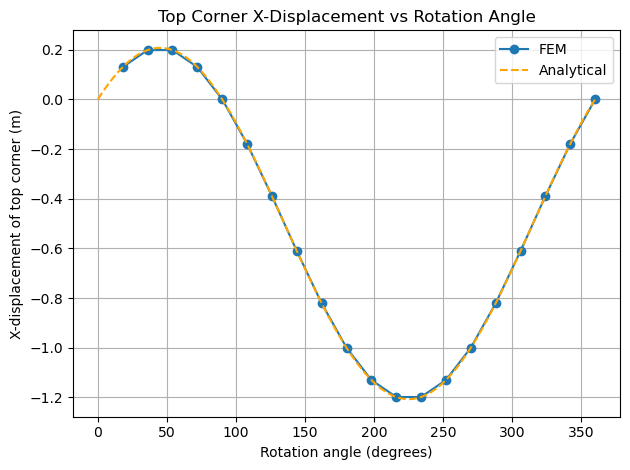

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# --- Analytical curve over smooth angle range ---
R = np.sqrt(0.5**2 + 0.5**2)         # Distance from rotation axis
phi0 = np.arctan2(0.5, 0.5)          # Initial angle = 45°
angles_smooth_deg = np.linspace(0, 360, 361)           # 0 to 360 degrees
angles_smooth_rad = np.radians(angles_smooth_deg)
analytical_dx = R * (np.cos(angles_smooth_rad - phi0) - np.cos(phi0))

# --- Plot ---
plt.figure()
plt.plot(angles_deg, corner_displacements_x, marker="o", label="FEM")
plt.plot(angles_smooth_deg, analytical_dx, linestyle="--", color="orange", label="Analytical")
plt.xlabel("Rotation angle (degrees)")
plt.ylabel("X-displacement of top corner (m)")
plt.title("Top Corner X-Displacement vs Rotation Angle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## The convergence of the solution is demonstrated.

## The solver can fail if only too few increments are used.